In [1]:
import pandas as pd
import numpy as np

In [2]:
#mount my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/df_scaled (3).csv")

In [4]:
# Drop Customer_ID (not useful for prediction)
df_cleaned = df.drop(columns=['Customer_ID'])

In [7]:
#drop outlet_city
df_cleaned = df_cleaned.drop(columns=['outlet_city'])

In [8]:
# Define features and target
X = df_cleaned.drop(columns=['cluster_catgeory'])  # Features
y = df_cleaned['cluster_catgeory']  # Target variable

In [37]:
X

,luxury_sales,fresh_sales,dry_sales,Outlet_No.
0,4.696228,0.562878,0.422784,1
1,4.693739,0.681120,0.533941,7
2,4.693739,0.641542,0.496740,11
3,4.691873,0.680716,0.533572,11
4,4.690940,0.522275,0.496204,7
...,...,...,...,...
774142,-1.524301,0.390870,0.181612,11
774143,-1.524301,0.352233,0.149568,4
774144,-1.524301,0.122702,0.023131,2
774145,-1.524301,0.000000,-0.121494,9


In [10]:
#check that the list of target variable
y.head()

,cluster_catgeory
0,3
1,3
2,3
3,3
4,3


In [11]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# Now use the encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=14, stratify=y_encoded)


#This is to show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)


X_train Instances (619317, 4)
X_test Instances (154830, 4)


# Handled imbalanced data

In [12]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Model Development

In [13]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [14]:
import lightgbm as lgb

# Optimized parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": "multi_logloss",
    "boosting_type": "dart",
    "learning_rate": 0.03,
    "class_weight" : "balanced",
    "num_leaves": 10,
    "max_depth": 3,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 3,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}

In [15]:
num_boost_round = 150  # Number of trees

# Train LightGBM with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 907110, number of used features: 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [16]:
 #Make predictions
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(line) for line in y_pred]  # Convert probability output to class

# Evaluating Modeling

In [17]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.9595
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     37797
           1       0.96      0.99      0.98     31013
           2       0.86      0.83      0.84      9781
           3       0.96      0.99      0.98     34488
           4       0.80      0.83      0.81      7908
           5       0.99      0.96      0.98     33843

    accuracy                           0.96    154830
   macro avg       0.93      0.93      0.93    154830
weighted avg       0.96      0.96      0.96    154830



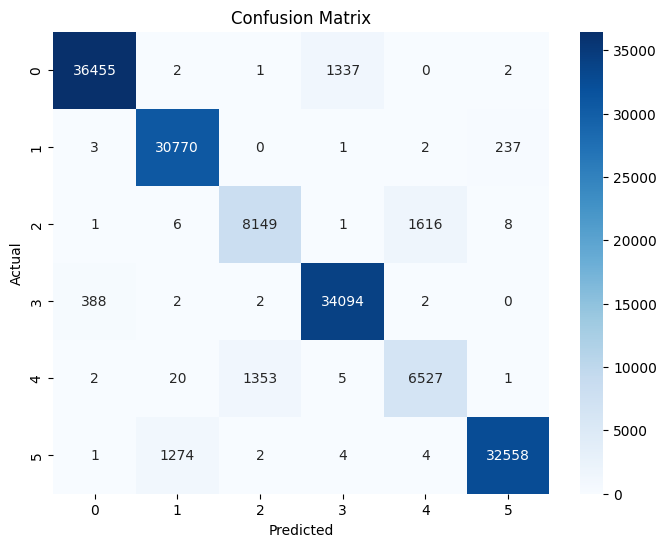

In [18]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. C

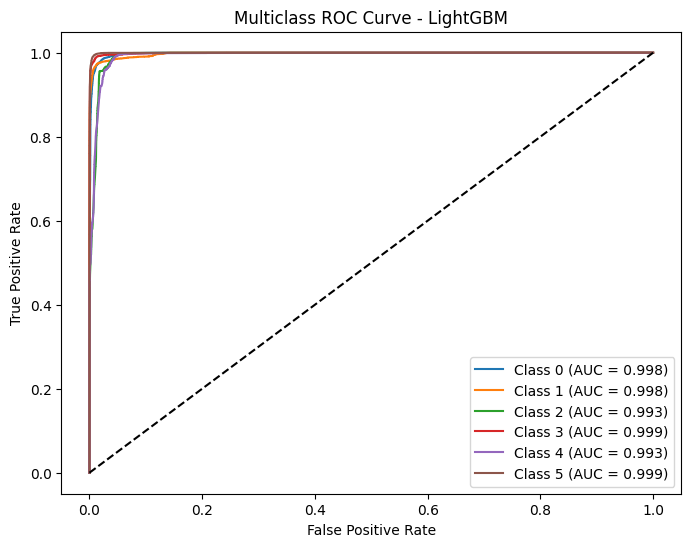

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# Initialize the LGBMClassifier with the same parameters but remove early_stopping_rounds
# Create a copy of the original params and remove 'early_stopping_rounds'
roc_params = params.copy()
del roc_params['early_stopping_rounds']

# Initialize and train the model for ROC curve
model_roc = LGBMClassifier(**roc_params)  # unpack the modified params here
model_roc.fit(X_train, y_train)

# Convert y_test to a binarized format (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=model_roc.classes_) # Using the fitted model

# Get probability scores for all classes using X_val (your validation data)
y_probs = model_roc.predict_proba(X_test) # Using the fitted model

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))

for i in range(y_test_binarized.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {model_roc.classes_[i]} (AUC = {auc_score:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - LightGBM') # Corrected the title
plt.legend()
plt.show()

# Feature Importance

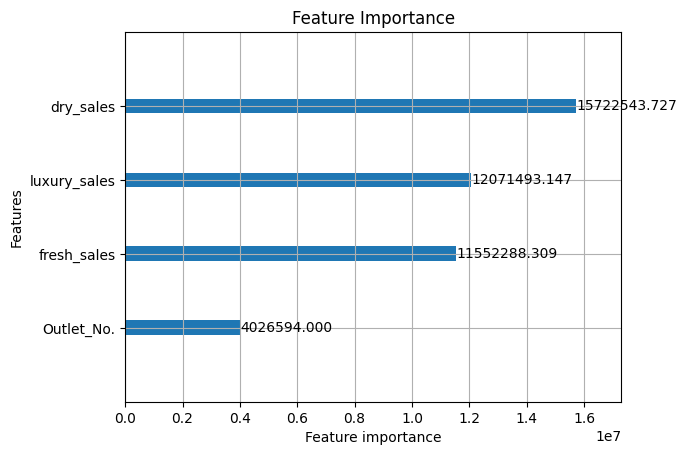

In [19]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

# Installing lightBGM

In [20]:
!pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


# Loss curve

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 907110, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

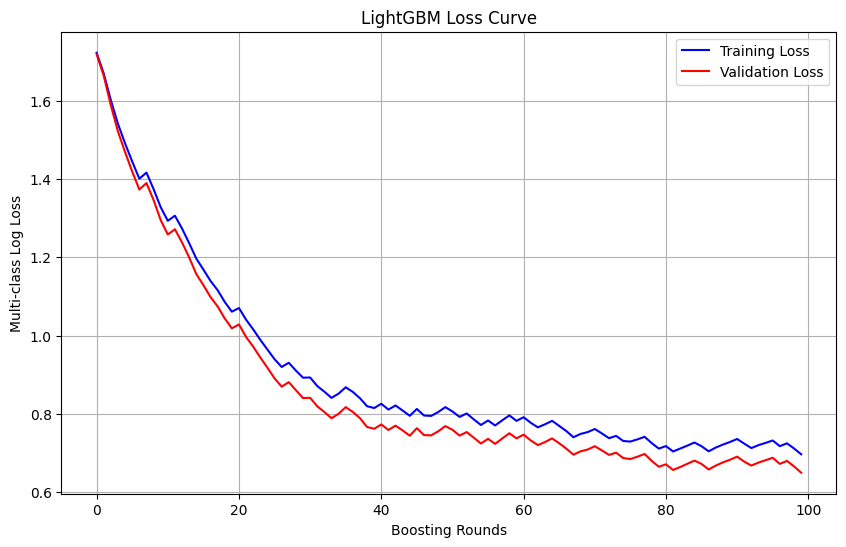

In [21]:
import lightgbm as lgb

# Dictionary to store training history
evals_result = {}

import warnings
warnings.filterwarnings("ignore")

# Train LightGBM model and log loss values
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # Monitor both training & validation loss
    valid_names=["Train", "Validation"],
    num_boost_round=100,
    # 'early_stopping_rounds' is moved to the callbacks list
    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)

# Extract loss values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]
epochs = range(len(train_loss))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

Both the training and validation loss steadily decrease over the boosting rounds and the gap is low also showing that the model is learning effectively. That means the model is not overfitting.

# **Cross validation**

In [28]:
##cross validation
# Perform 5-Fold Cross-Validation
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier # Import the LGBMClassifier

# Initialize the LGBMClassifier with the same parameters but remove early_stopping_rounds
# Create a copy of the original params and remove 'early_stopping_rounds'
cv_params = params.copy()
del cv_params['early_stopping_rounds']

model = LGBMClassifier(**cv_params) # unpack the modified params here

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Light BGM CV Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. C

Result of cross validations

In [33]:
print("Light BGM CV Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Light BGM CV Accuracy Scores: [0.91571584 0.91358821 0.91636075 0.91496621 0.92110659]
Mean Accuracy: 0.9163475212488011
Standard Deviation: 0.0025522445091438464
